## Make necessary imports

In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
np.set_printoptions(precision=3, linewidth=200, suppress=True)
from library.datasets.cifar10 import CIFAR10
from library.hog.hog import HOG
from library.utils import file_utils
import tensorflow as tf
from library.tf.MLPClassifier import TFMLPClassifier
import time

None


## Select Tensorflow device

In [2]:
# from tensorflow.python.client import device_lib
# local_device_protos = device_lib.list_local_devices()
# cpu_devices = [x.name for x in local_device_protos if x.device_type == 'CPU']
# gpu_devices = [x.name for x in local_device_protos if x.device_type == 'GPU']
# print('Available CPU Devices: ', end='')
# print(cpu_devices)
# print('Available GPU Devices: ', end='')
# print(gpu_devices)
# if len(gpu_devices) == 0:
#     if len(cpu_devices) > 0:
#         device_name = '/cpu:0'
#         print('Using CPU: %s' %device_name)
#     else:
#         print('No CPU present in the system!!!')
# else:
#     device_name = '/gpu:0'
#     print('Using GPU: %s' %device_name)

In [3]:
total_time = 0

## Experiment

In [4]:
exp_no = 4
data_source = 'Website'
num_images_required = 1.0
file_no = 13

### Parameters for experiment

In [5]:
block_size = (8,8)
cell_size = (2,2)
nbins = 9

In [6]:
device_name = '/gpu:0'
learning_rate = 1.5
training_epochs = 20
display_step = 1
regularize=False
regularization_const = [0.01]
train_validate_split_data = None
train_validate_split = 0.8
transform=True
transform_method='StandardScaler'
learning_rate_type='constant'
dataset = 'cifar10'
hidden_layers=[100,100]
batch_size=1000
init_weights=['random_normal']
init_bias=['random_normal']
activation_fn=['sigmoid']
activation_req=True
descent_method='gradient'

### Log directories

In [7]:
log_dir = '../logs/' + dataset + '/' + str(file_no).zfill(2) + '_tf_mlp_test/exp_no_' + str(exp_no).zfill(3) + '/'
log_file = log_dir + 'mlp_classifier.ckpt'
print('Writing tensorboard logs to %s' %log_file)
print('view logs by running tensorboard: ', end='')
print('\"tensorboard --logdir=\'./10_tf_mlp/\' --port 61111\"')

Writing tensorboard logs to ../logs/cifar10/13_tf_mlp_test/exp_no_004/mlp_classifier.ckpt
view logs by running tensorboard: "tensorboard --logdir='./10_tf_mlp/' --port 61111"


## Step 1: Load CIFAR 10 Dataset

In [8]:
one_hot = True
make_image = True
mode='rgb'
cifar10 = CIFAR10(one_hot_encode=one_hot, num_images=num_images_required, make_image=make_image, image_mode=mode,
                  train_validate_split=train_validate_split_data, endian='little')
cifar10.load_data(train=True, test=True, data_directory='./datasets/cifar10/')

Loading CIFAR 10 Dataset
MD5sum of the file: ./datasets/cifar10/cifar-10.tar.gz is verified
Loading 50000 train images
Loading CIFAR 10 Training Dataset
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_1
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_2
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_3
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_4
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_5
Loading 10000 test images
Loading CIFAR 10 Test Dataset
Unpickling test file: ./datasets/cifar10/cifar-10-batches/test_batch
Reading unpicked test file: ./datasets/cifar10/cifar-10-batches/test_batch
Loaded CIFAR 10 Dataset in 2.0918 seconds


True

In [9]:
print('Train data shape:', cifar10.train.data.shape)
if one_hot is True:
    print('Train labels shape:', cifar10.train.one_hot_labels.shape)
if make_image is True:
    print('Train images shape:', cifar10.train.images.shape)
print('Train class labels shape:', cifar10.train.class_labels.shape)
if train_validate_split_data is not None:
    print('Validate data shape:', cifar10.validate.data.shape)
    if one_hot is True:
        print('Validate labels shape:', cifar10.validate.one_hot_labels.shape)
    if make_image is True:
        print('Validate images shape:', cifar10.vaidate.images.shape)
    print('Validate class labels shape:', cifar10.validate.class_labels.shape)
print('Test data shape:', cifar10.test.data.shape)
if one_hot is True:
    print('Test labels shape:', cifar10.test.one_hot_labels.shape)
if make_image is True:
    print('Test images shape:', cifar10.test.images.shape)
print('Test class labels shape:', cifar10.test.class_labels.shape)

Train data shape: (50000, 3072)
Train labels shape: (50000, 10)
Train images shape: (50000, 32, 32, 3)
Train class labels shape: (50000,)
Test data shape: (10000, 3072)
Test labels shape: (10000, 10)
Test images shape: (10000, 32, 32, 3)
Test class labels shape: (10000,)


In [10]:
print('Training images')
print(cifar10.train.data[:5])
if make_image is True and mode=='rgb':
    print('Training images rgb')
    print(cifar10.train.images[:5])
if make_image is True and mode=='float':
    print('Training images float')
    print(cifar10.train.images[:5])
if one_hot is True:
    print('Training labels')
    print(cifar10.train.one_hot_labels[:5])
print('Training classes')
print(cifar10.train.class_labels[:5])
print('Testing images')
print(cifar10.test.data[:5])
if make_image is True and mode=='rgb':
    print('Testing images rgb')
    print(cifar10.test.images[:5])
if make_image is True and mode=='float':
    print('Testing images float')
    print(cifar10.test.images[:5])
if one_hot is True:
    print('Testing labels')
    print(cifar10.test.one_hot_labels[:5])
print('Testing classes')
print(cifar10.test.class_labels[:5])

Training images
[[ 59  43  50 ..., 140  84  72]
 [154 126 105 ..., 139 142 144]
 [255 253 253 ...,  83  83  84]
 [ 28  37  38 ...,  28  37  46]
 [170 168 177 ...,  82  78  80]]
Training images rgb
[[[[  59.   62.   63.]
   [  43.   46.   45.]
   [  50.   48.   43.]
   ..., 
   [ 158.  132.  108.]
   [ 152.  125.  102.]
   [ 148.  124.  103.]]

  [[  16.   20.   20.]
   [   0.    0.    0.]
   [  18.    8.    0.]
   ..., 
   [ 123.   88.   55.]
   [ 119.   83.   50.]
   [ 122.   87.   57.]]

  [[  25.   24.   21.]
   [  16.    7.    0.]
   [  49.   27.    8.]
   ..., 
   [ 118.   84.   50.]
   [ 120.   84.   50.]
   [ 109.   73.   42.]]

  ..., 
  [[ 208.  170.   96.]
   [ 201.  153.   34.]
   [ 198.  161.   26.]
   ..., 
   [ 160.  133.   70.]
   [  56.   31.    7.]
   [  53.   34.   20.]]

  [[ 180.  139.   96.]
   [ 173.  123.   42.]
   [ 186.  144.   30.]
   ..., 
   [ 184.  148.   94.]
   [  97.   62.   34.]
   [  83.   53.   34.]]

  [[ 177.  144.  116.]
   [ 168.  129.   94.]
   [

In [11]:
start = time.time()
data_hog = []
feature_size = 0
hog = HOG(block_size=block_size, cell_size=cell_size, nbins=nbins)
print('Generating HOG features for %d data images' %cifar10.train.images.shape[0])
for fig_num in range(cifar10.train.images.shape[0]):
    img = cifar10.train.images[fig_num, :]
    gradients = hog.make_hog_gradients(img.astype('uint8'))
    data_hog.append(gradients.flatten())
    feature_size = gradients.size
data_hog = np.array(data_hog)
print('HOG Features for data: ' + str(data_hog.shape))
end = time.time()
print('Generated HOG for train images in %.6f ms' %((end-start)*1000))

Generating HOG features for 50000 data images
HOG Features for data: (50000, 2304)
Generated HOG for train images in 37833.537340 ms


In [12]:
start = time.time()
test_hog = []
feature_size = 0
print('Generating HOG features for %d test images' %cifar10.test.images.shape[0])
for fig_num in range(cifar10.test.images.shape[0]):
    img = cifar10.test.images[fig_num, :]
    gradients = hog.make_hog_gradients(img.astype('uint8'))
    test_hog.append(gradients.flatten())
    feature_size = gradients.size
test_hog = np.array(test_hog)
print('HOG Features for test: ' + str(test_hog.shape))
end = time.time()
print('Generated HOG for test images in %.6f ms' %((end-start)*1000))

Generating HOG features for 10000 data images
HOG Features for test: (10000, 2304)
Generated HOG for test images in 7761.145592 ms


## Step 1.1 Load sample images

Plotting CIFAR 10 Train Dataset


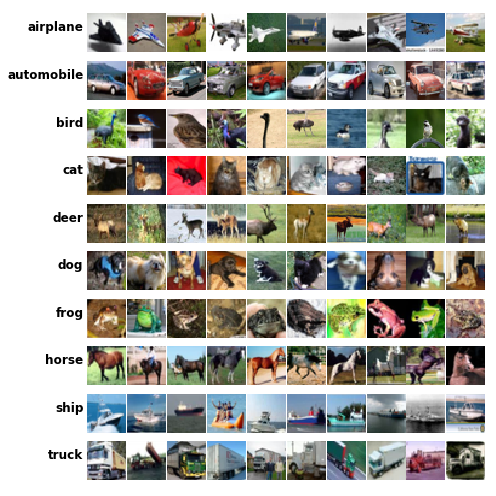

Plotting CIFAR 10 Test Dataset


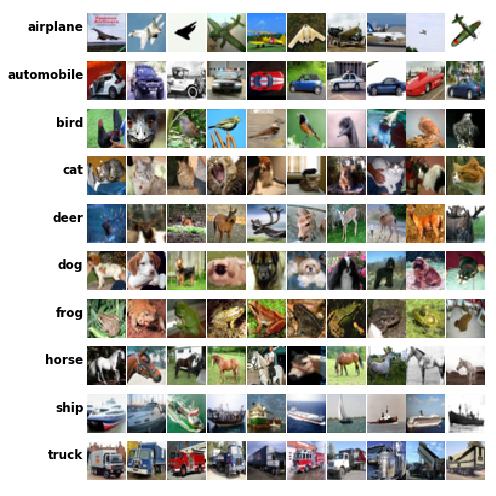

In [13]:
cifar10.plot_sample(plot_data=True, plot_test=True, fig_size=(7, 7))

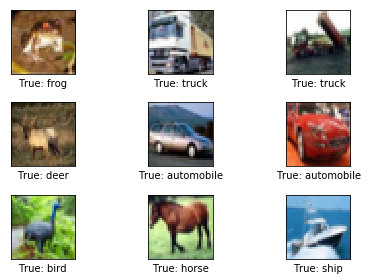

True

In [14]:
cifar10.plot_images(cifar10.train.data[:9, :], cifar10.train.class_names[:9])

## Step 2: Multi layer perceptron

### Step 2.1: Model MLP

In [15]:
num_features = data_hog.shape[1]
num_classes = 10

In [16]:
tf_lc = TFMLPClassifier(verbose=True, device=device_name, session_type='interactive', learning_rate=learning_rate,
                        num_iterations=training_epochs, display_step=display_step, save_model=True, restore=True,
                        regularize=regularize, reg_const=regularization_const, train_validate_split=train_validate_split, 
                        init_weights=init_weights, init_bias=init_bias, model_name=log_file, log_dir=log_dir, 
                        learning_rate_type=learning_rate_type, test_log=True, separate_writer=False, batch_size=batch_size,
                        nodes_in_layers=hidden_layers,activation_fn=activation_fn,activation_req=activation_req,
                        descent_method=descent_method)
print(tf_lc)

### Step 2.2: Create the tensorflow graph

In [17]:
tf_lc.create_graph(num_features=num_features, num_classes=num_classes)

[100, 100]
Tensorflow graph created in 0.6848 seconds


True

In [18]:
print(tf_lc.print_parameters())

>> Parameters for Linear Classifier
Activation function        :  ['sigmoid', 'sigmoid']
Gradient Descent Method    :  gradient
Learning rate type         :  constant
Learning rate              :  1.5
Error Tolerance            :  1e-07
Data Transformation method :  StandardScaler
>> Inputs for Tensorflow Graph
X                          :  Tensor("Inputs/Data/X:0", shape=(?, 2304), dtype=float32, device=/device:GPU:0)
Y_true                     :  Tensor("Inputs/Train_Labels/y_label:0", shape=(?, 10), dtype=float32, device=/device:GPU:0)
Y_true_cls                 :  Tensor("Inputs/Train_Labels/y_class:0", shape=(?,), dtype=int64, device=/device:GPU:0)
Device to use              :  /gpu:0
>> Output parameters for Tensorflow Graph
W                          : {'weight_0': <tensorflow.python.ops.variables.Variable object at 0x7f400558d390>, 'weight_1': <tensorflow.python.ops.variables.Variable object at 0x7f3ffce488d0>}
Init Weights               : ['random_normal', 'random_normal']
  w

### Step 2.3: Fit the model/training

In [19]:
print(data_hog.shape)
print(test_hog.shape)
tf_lc.fit(data_hog, cifar10.train.one_hot_labels, cifar10.train.class_labels,
          test_data=test_hog, test_labels=cifar10.test.one_hot_labels, test_classes=cifar10.test.class_labels)

(50000, 2304)
(10000, 2304)
Using GPU:  /gpu:0
Session: <tensorflow.python.client.session.InteractiveSession object at 0x7f3ffce21978>
Data shape             : (50000, 2304)
Labels shape           : (50000, 10)
Classes shape          : (50000,)
Train Data shape       : (40000, 2304)
Train Labels shape     : (40000, 10)
Train Classes shape    : (40000,)
Validate Data shape    : (10000, 2304)
Validate Labels shape  : (10000, 10)
Validate Classes shape : (10000,)
Length of train loss          : 0
Length of train accuracy      : 0
Length of validate loss       : 0
Length of validate accuracy   : 0
Length of test accuracy       : 0
Restoring training from epoch : 0
>>> Epoch [ 0/20]
train_loss: 3.2939 | train_acc: 0.2040 | val_loss: 3.3226 | val_acc: 0.2219 | test_acc: 0.0998 | Time: 2.1207 s
>>> Epoch [ 1/20]
train_loss: 2.4704 | train_acc: 0.2740 | val_loss: 2.6491 | val_acc: 0.2481 | test_acc: 0.1000 | Time: 1.5667 s
>>> Epoch [ 2/20]
train_loss: 2.2709 | train_acc: 0.2850 | val_loss: 2.

### Step 2.4: Print the results

In [20]:
test_accuracy = tf_lc.print_accuracy(test_hog, cifar10.test.one_hot_labels, cifar10.test.class_labels)
print('Accuracy of the linear classifier on test dataset: %.4f' %test_accuracy)

Accuracy of the linear classifier on test dataset: 0.0981


In [21]:
tf_lc.print_classification_results(test_hog, cifar10.test.one_hot_labels, cifar10.test.class_labels)

Confusion matrix
[[ 57 108 199 153  11  11 103 140 133  85]
 [ 67 112 198 124  10   5 103 154 129  98]
 [ 73 128 175 164  12  12 110 131 116  79]
 [ 68 122 183 155  15   7  93 159 101  97]
 [ 64 129 178 134  15   4 105 155 113 103]
 [ 62 130 159 149   9   9 109 162 109 102]
 [ 57 123 176 126  10  17 108 153 136  94]
 [ 66 102 177 144  13  13 112 147 140  86]
 [ 56 117 192 136  13   6 106 158 112 104]
 [ 60 119 194 112  10   6 127 157 124  91]]
Detailed classification report
             precision    recall  f1-score   support

          0       0.09      0.06      0.07      1000
          1       0.09      0.11      0.10      1000
          2       0.10      0.17      0.12      1000
          3       0.11      0.15      0.13      1000
          4       0.13      0.01      0.03      1000
          5       0.10      0.01      0.02      1000
          6       0.10      0.11      0.10      1000
          7       0.10      0.15      0.12      1000
          8       0.09      0.11      0.10 

### Step 2.5: Close the session

In [22]:
tf_lc.close()

## Step 3: Write to file

In [23]:
def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    output_notebook = nbformat.read(read_file, as_version=4)
    print()
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [24]:
%%javascript
var notebook = IPython.notebook
notebook.save_notebook()

<IPython.core.display.Javascript object>

In [27]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [28]:
current_file = './' + theNotebook + '.ipynb'
output_file = log_dir + str(file_no).zfill(2) + '_exp_no_' + str(exp_no).zfill(3) + '_' + theNotebook + '.html'
print('Current file: ' + str(current_file))
print('Output file: ' + str(output_file))
file_utils.mkdir_p(log_dir) 
output_HTML(current_file, output_file)

Current file: ./13_Tensorflow_MLP_Classifier_HOG_features_CIFAR_10_Website.ipynb
Output file: ../logs/cifar10/13_tf_mlp_test/exp_no_004/13_exp_no_004_13_Tensorflow_MLP_Classifier_HOG_features_CIFAR_10_Website.html

